In [1]:
import numpy as np
import xarray as xr
import glob
import os
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
datadir='data/'
north_str = '600S'
#dset = '_southof%s_swmt_onvoffshelf_'%north_str # total
dset = '_southof%s_swmt_onvoffshelf_decomposed_'%north_str # decomposed
lstr = 'sigma2'
dl = '002'

In [3]:
ddict = {mod:{} for mod in ['CM4','ESM4']}
for mod in ddict:
    ddict_exp = {exp:{} for exp in ['control','antwater','stress','antwaterstress']}
    for exp in ddict_exp:
        
        if exp == 'control':
            head = '%s_%s'%(mod,exp)
            
            files = glob.glob(datadir+head+'_so_*'+dset+'%s_%s.nc'%(lstr,dl))
            
            if len(files)>1:
                print('WARNING: More than one file for '+head)
            elif len(files)==0:
                print('ERROR: No file available for '+head)
                ddict[mod] = []
                continue
                
            print('Loading '+os.path.basename(files[0]))
            ddict_exp[exp] = xr.open_dataset(files[0])
                
        else:
            ddict_mem = {mem:{} for mem in (['251', '290', '332'] if mod=='CM4' else ['101', '151', '201'])}
            for mem in ddict_mem:
                head = '%s_%s_%s'%(mod,exp,mem)   
                files = glob.glob(datadir+head+'_so_*'+dset+'%s_%s.nc'%(lstr,dl))
                
                if len(files)>1:
                    print('WARNING: More than one file for '+head)
                elif len(files)==0:
                    print('ERROR: No file available for '+head)
                    ddict_mem[mem] = []
                    continue
                    
                print('Loading '+os.path.basename(files[0]))
                ddict_mem[mem] = xr.open_dataset(files[0])
            ddict_exp[exp] = ddict_mem
    ddict[mod] = ddict_exp

Loading CM4_control_so_0251to0395_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc
Loading CM4_antwater_251_so_0001to0100_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc
Loading CM4_antwater_290_so_0001to0070_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc
Loading CM4_antwater_332_so_0001to0070_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc
Loading CM4_stress_251_so_0001to0100_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc
Loading CM4_stress_290_so_0001to0070_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc
Loading CM4_stress_332_so_0001to0070_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc
Loading CM4_antwaterstress_251_so_0001to0100_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc
Loading CM4_antwaterstress_290_so_0001to0070_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc
Loading CM4_antwaterstress_332_so_0001to0070_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc
Loading ESM4_control_so_0101to0270_southof600S_swmt_onvoffshelf

In [4]:
tctr_cm4 = ['0281', '0380']
tctr_esm4 = ['0121', '0220']
texp = ['0051','0070']

In [5]:
mndict = {mod:{} for mod in list(ddict.keys())}
for mod in ddict:
    mndict[mod] = {exp:{} for exp in list(ddict[mod].keys())}
    
for mod in mndict:
    for exp in mndict[mod]:
        
        if exp=='control':
            yr_st = tctr_cm4[0] if mod=='CM4' else tctr_esm4[0]
            yr_ed = tctr_cm4[1] if mod=='CM4' else tctr_esm4[1]
            mndict[mod][exp] = ddict[mod][exp].sel(time=slice(yr_st,yr_ed)).mean('time')*1e-6
        else:
            yr_st,yr_ed = '0051','0070'
            Gs = []
            for mem in (['251', '290', '332'] if mod=='CM4' else ['101', '151', '201']):
                
                G = ddict[mod][exp][mem]*1e-6
                if mem == '101':
                    G['time'] = G.time - timedelta(days=365*(int(mem)-1))
    
                G['mem'] = int(mem)
                Gs.append(G)
                
            mndict[mod][exp] = xr.concat(Gs, dim='mem').sel(time=slice(yr_st,yr_ed)).mean('time')

In [6]:
ddict_wm = {mod:{} for mod in ['CM4','ESM4']}
ddict_wm['CM4']['water_mass'] = ['Upper Ocean','SAMW','AAIW','CDW','AABW']
ddict_wm['CM4']['sig2'] = [35.6, 36.1, 36.6, 37.06]
ddict_wm['ESM4']['water_mass'] = ['Upper Ocean','SAMW','AAIW','CDW','AABW']
ddict_wm['ESM4']['sig2'] = [35.2, 35.6, 36.5, 37.03]

### Figure 11

In [7]:
lttr = [['a','b'],['c','d']]

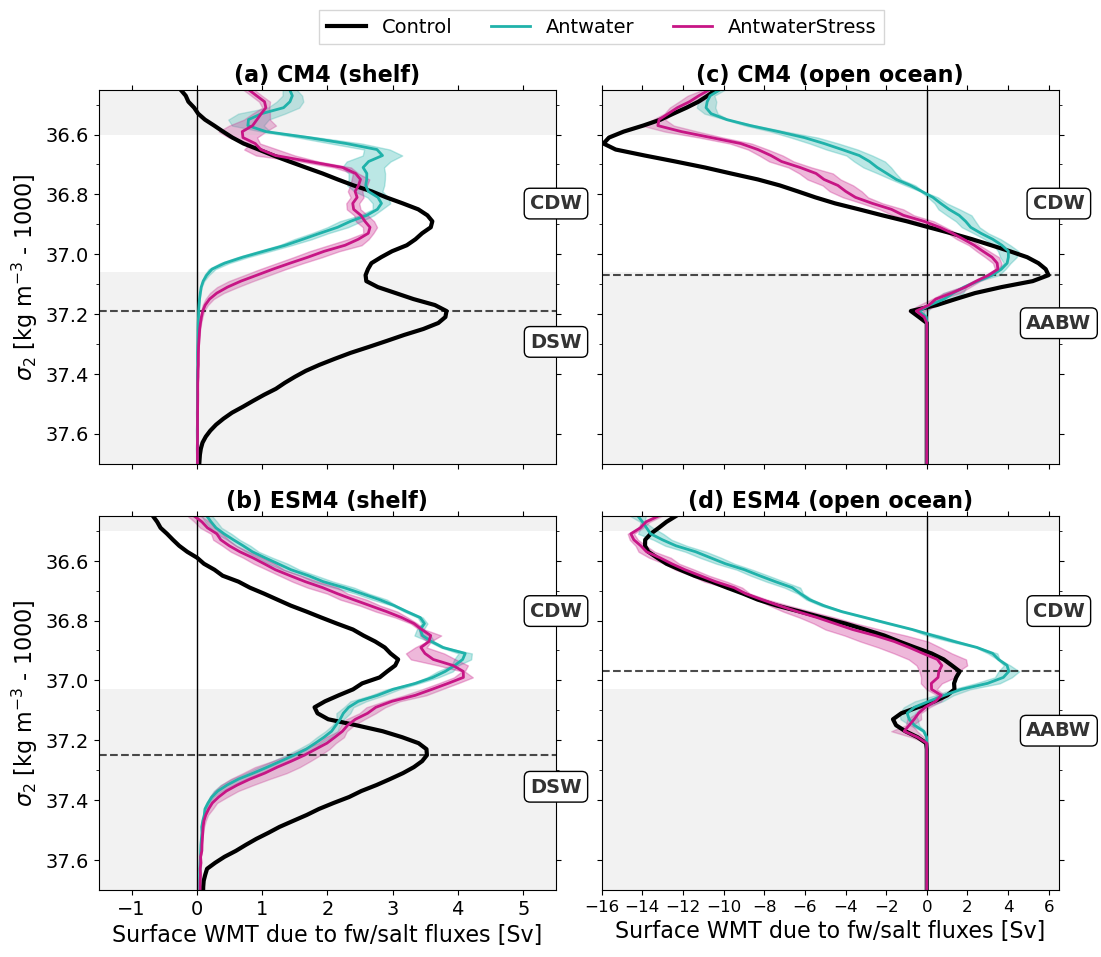

In [8]:
var = 'salt' # total, heat, salt
cstr = ['k','lightseagreen','mediumvioletred']

fig, axs = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(12,10))
#fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.05, wspace=0.1)
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.14, wspace=0.1)
for i, reg in enumerate(['onshlf','offshr']):
    for j, mod in enumerate(ddict):
    
        axs[j,i].axvline(x=0, ymin=0, ymax=1, linewidth=1.0, color = 'k')

        for k, exp in enumerate(['control','antwater','antwaterstress']):
            
            if exp!='control':
                da = mndict[mod][exp][reg+'_'+var]
                axs[j,i].fill_betweenx(da[lstr], da.mean('mem')-da.std('mem'), da.mean('mem')+da.std('mem'), 
                                       alpha=0.3, edgecolor=cstr[k], facecolor=cstr[k])
            else:
                da = mndict[mod][exp][reg+'_'+var]
                sig_max = np.round(da[da.argmax()][lstr].values,2)
                G_max = np.round(da[da.argmax()].values,2)
                axs[j,i].axhline(y=sig_max, xmin=0, xmax=1, linewidth=1.5, color = 'k',alpha=0.7,ls='--')
                
            da = mndict[mod][exp][reg+'_'+var] if exp =='control' else mndict[mod][exp][reg+'_'+var].mean('mem')
            axs[j,i].plot(da, da[lstr], c=cstr[k], ls='-', lw=3 if exp =='control' else 2,
                          label=exp[:8].capitalize()+exp[8:].capitalize() if exp =='antwaterstress' \
                          else exp.capitalize())
            
        if (reg == 'onshlf') & (mod=='CM4'):
            axs[j,i].legend(frameon=True, fancybox=False, bbox_to_anchor=(1.1, 1.24), #(1.1, 1.14), 
                            loc='upper center', ncol=3, fontsize=14)
            
            
        if reg == 'onshlf':
            axs[j,i].set_ylabel(r'$\sigma_2$ [kg m$^{-3}$ - 1000]',fontsize=16)
            axs[j,i].set_xlim([-1.5,5.5])
            axs[j,i].set_xticks(np.arange(-1,6,1))
        else:
            axs[j,i].set_yticklabels([])
            axs[j,i].set_xlim([-16,6.5])
            axs[j,i].set_xticks(np.arange(-16,8,2))
        
        if mod == 'CM4':
            axs[j,i].set_xticklabels([])
        else:
            axs[j,i].set_xlabel(r'Surface WMT due to fw/salt fluxes [Sv]',fontsize=16)
            
        axs[j,i].set_ylim([36.45,37.7])
        axs[j,i].set_yticks(np.arange(36.5,37.5,0.1), minor=True)

        xlimit = axs[j,i].get_xlim()
        ylimit = axs[j,i].get_ylim()
        
        widx=2
        xy = (xlimit[0],ylimit[0])
        rwidth = ddict_wm[mod]['sig2'][widx]-ylimit[0]
        rect = axs[j,i].add_patch(plt.Rectangle(xy, abs(xlimit[1]-xlimit[0]), rwidth,facecolor='silver',
                                                clip_on=False,linewidth = 0,alpha=0.2)) 
        
        widx=4
        xy = xlimit[0], ddict_wm[mod]['sig2'][widx-1]
        rwidth = ylimit[1]-ddict_wm[mod]['sig2'][widx-1]
        rect = axs[j,i].add_patch(plt.Rectangle(xy, abs(xlimit[1]-xlimit[0]), rwidth,facecolor='silver',
                                                clip_on=False,linewidth = 0,alpha=0.2))
        
        axs[j,i].text(1, 0.67 if mod =='CM4' else 0.72, 'CDW', fontsize=14, fontweight='bold',
                ha='center', va='bottom',color='k',alpha=0.8,#rotation=270,
                bbox=dict(boxstyle="round",ec='k',fc='w'), transform=axs[j,i].transAxes)
        axs[j,i].text(1, 0.25 if (reg=='onshlf')&(mod =='ESM4') else 0.3 if (reg=='onshlf')&(mod =='CM4') \
                      else 0.4 if (reg=='offshr')&(mod =='ESM4') else 0.35, 'DSW' if reg=='onshlf' else 'AABW', 
                      fontsize=14, fontweight='bold',ha='center', va='bottom',color='k',alpha=0.8,
                      bbox=dict(boxstyle="round",ec='k',fc='w'), transform=axs[j,i].transAxes)  
        
        axs[j,i].tick_params(axis='both', which='both', labelsize=14 if reg=='onshlf' else 12, top=True,right=True)
        axs[j,i].invert_yaxis()
        axs[j,i].set_title('(%s) %s (%s)'%(lttr[i][j],mod,'shelf' if reg=='onshlf' else 'open ocean'),
                           fontsize=16,fontweight='bold')

plt.savefig('shlf_vs_offshr.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

**Figure 11**: Surface-forced water mass transformation (WMT) south of 60$^\circ$S decomposed by transformation occurring over the Antarctic shelf (left column) and over the open ocean (right column) for CM4 (top row) and ESM4 (bottom row). Black lines represent the 100-year mean from the corresponding Control run, while the colored lines represent the 20-year mean of Antwater (cyan) and AntwaterStress (magenta). WMT is presented in $\sigma_2$-space with density bins of 0.02 kg m$^{-3}$. Positive values correspond to transport towards denser water classes and negative transformation to lighter water classes. The 20-year mean WMT curves for Antwater and AntwaterStress include $\pm$1 standard deviation envelope based on the ensemble.

### Surface WMT on the shelf versus offshore (total)
`dset = '_southof%s_swmt_'%north_str`

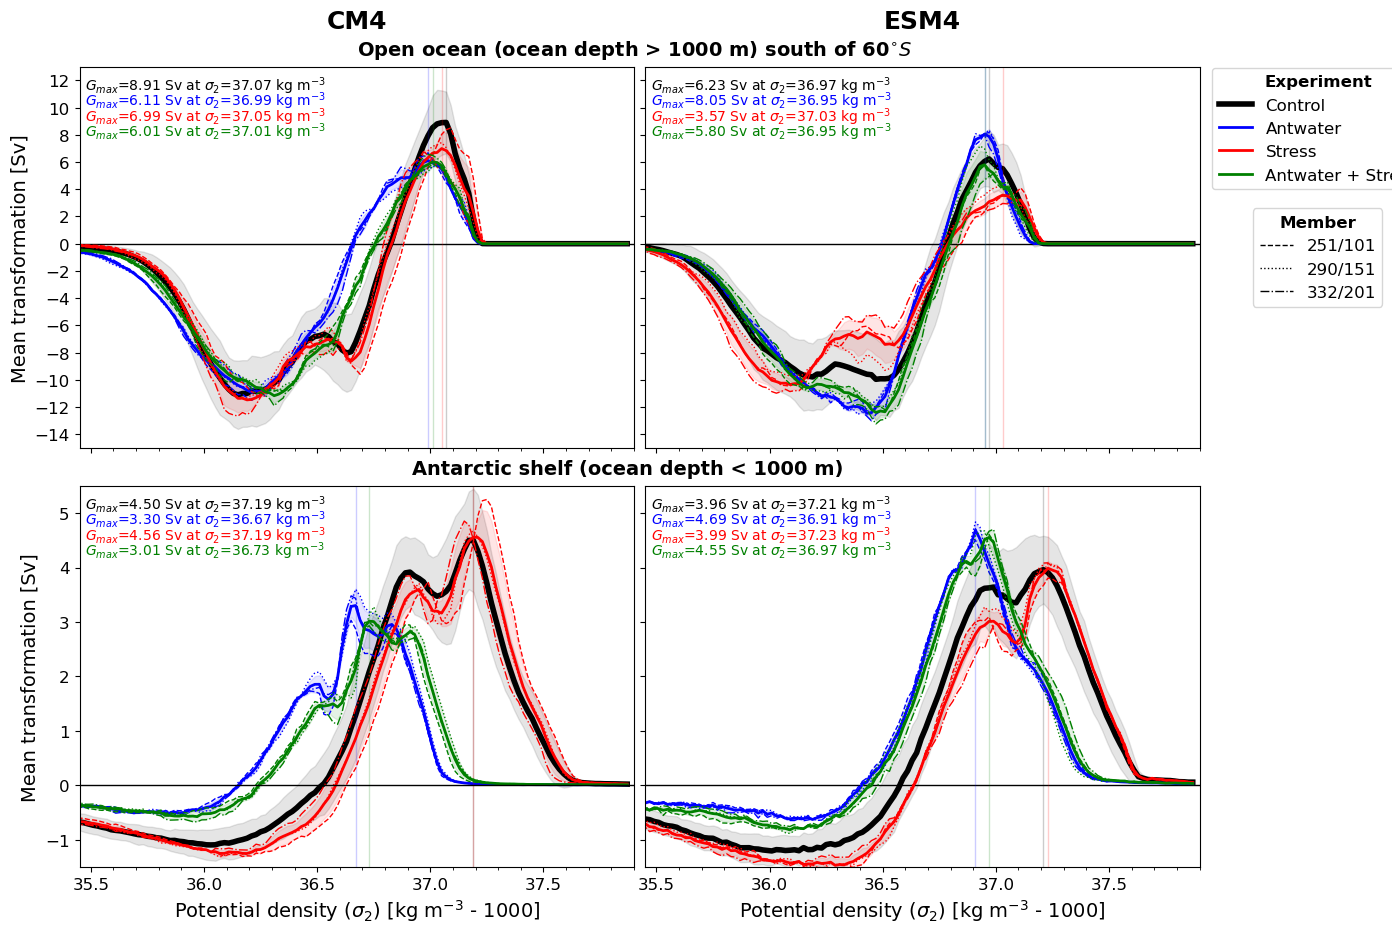

In [15]:
cstr = ['k','b','r','g']
lsty = ['--',':','-.']

fig, axs = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(14,10))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.1, wspace=0.02)

for i, mod in enumerate(ddict):
    for j, reg in enumerate(['offshr','onshlf']):
        axs[i,j].axhline(y=0, xmin=0, xmax=1, c = 'k', lw=1.0, ls='-')
        
        
        for k, exp in enumerate(ddict[mod]):
            
            if exp!='control':
                da = mndict[mod][exp][reg]
                axs[j,i].fill_between(da[lstr], da.mean('mem')-da.std('mem'), da.mean('mem')+da.std('mem'), 
                                      alpha=0.1, edgecolor=cstr[k], facecolor=cstr[k])
                
                for m, mem in enumerate(ddict[mod][exp]):
                    axs[j,i].plot(da[lstr], da.sel(mem=int(mem)), color=cstr[k], ls=lsty[m], lw=1, label=mem)
                    
            else:
                yr_st = tctr_cm4[0] if mod=='CM4' else tctr_esm4[0]
                yr_ed = tctr_cm4[1] if mod=='CM4' else tctr_esm4[1]
                da = ddict[mod][exp].sel(time=slice(yr_st,yr_ed))[reg]*1e-6
                axs[j,i].fill_between(da[lstr], 
                                      da.mean('time')-da.groupby('time.year').mean('time').std('year'), 
                                      da.mean('time')+da.groupby('time.year').mean('time').std('year'), 
                                      alpha=0.1, edgecolor=cstr[k], facecolor=cstr[k])
        
            da = mndict[mod][exp][reg] if exp =='control' else mndict[mod][exp][reg].mean('mem')
   
            sig_max = np.round(da[da.argmax()][lstr].values,2)
            G_max = np.round(da[da.argmax()].values,2)
            axs[j,i].axvline(x=sig_max, c = cstr[k], ls='-', lw=1, alpha=0.2,
                             label=r'$G_{max}$=%.2f Sv at $\sigma_%s$=%.2f kg m$^{-3}$'%(G_max,lstr[-1],sig_max))
            axs[j,i].text(0.01, 0.98-k/25, 
                          r'$G_{max}$=%.2f Sv at $\sigma_%s$=%.2f kg m$^{-3}$'%(G_max,lstr[-1],sig_max), 
                          ha='left', va='top', fontsize=10, c = cstr[k], transform=axs[j,i].transAxes)
                    
            if exp=='control':
                p1, = axs[j,i].plot(mndict[mod][exp][lstr], mndict[mod][exp][reg], 
                                   c=cstr[k], ls='-', lw=4, label=exp.capitalize())
            elif exp=='antwater':
                p2, = axs[j,i].plot(mndict[mod][exp][lstr], mndict[mod][exp][reg].mean('mem'), 
                                   c=cstr[k], ls='-', lw=2, label=exp.capitalize())
            elif exp=='stress':
                p3, = axs[j,i].plot(mndict[mod][exp][lstr], mndict[mod][exp][reg].mean('mem'), 
                                   c=cstr[k], ls='-', lw=2, label=exp.capitalize())
            elif exp=='antwaterstress':
                p4, = axs[j,i].plot(mndict[mod][exp][lstr], mndict[mod][exp][reg].mean('mem'), 
                                   c=cstr[k], ls='-', lw=2, label=exp[:8].capitalize()+' + '+exp[8:].capitalize())
                
                for m, mem in enumerate(ddict[mod][exp]):
                    da = mndict[mod][exp][reg]
                    p5, = axs[j,i].plot(da[lstr]*(-1), da.isel(mem=0), color='k', ls=lsty[0], lw=1, label='251/101')
                    p6, = axs[j,i].plot(da[lstr]*(-1), da.isel(mem=1), color='k', ls=lsty[1], lw=1, label='290/151')
                    p7, = axs[j,i].plot(da[lstr]*(-1), da.isel(mem=2), color='k', ls=lsty[2], lw=1, label='332/201')
            
        axs[j,i].tick_params(axis='both', which='major', labelsize=12)
        
        if lstr=='sigma2':
            axs[j,i].set_xlim([35.45,37.8])
            axs[j,i].set_xticks(np.arange(35.5,38,0.1), minor=True)
        elif lstr=='sigma1':
            axs[j,i].set_xlim([31.1,33.1])
            axs[j,i].set_xticks(np.arange(31.2,33,0.2))#, minor=True)
            
        if reg != 'onshlf':
            axs[j,i].set_xticklabels([])
            axs[j,i].set_ylim([-15,13])
            axs[j,i].set_yticks(np.arange(-14,14,2))
        else:
            axs[j,i].set_xlabel('Potential density ($\sigma_%s$) [kg m$^{-3}$ - 1000]'%lstr[-1],fontsize=14)
            axs[j,i].set_ylim([-1.5,5.5])
            axs[j,i].set_yticks(np.arange(-1,6,1))
            
        if mod == 'CM4':
            axs[j,i].set_ylabel('Mean transformation [Sv]',fontsize=14)
        else:
            axs[j,i].set_yticklabels([])
            

axs[0,0].text(0.5, 1.03, 'Open ocean (ocean depth > 1000 m) south of 60$^{\circ}S$', 
              fontsize=14, fontweight='bold',transform=axs[0,0].transAxes)
axs[1,0].text(0.6, 1.03, 'Antarctic shelf (ocean depth < 1000 m)', 
              fontsize=14, fontweight='bold', transform=axs[1,0].transAxes)

for i, ax in enumerate(axs.flatten()[:2]):
    ax.set_title(list(ddict.keys())[i], fontweight='bold',fontsize=18, y=1.08)
    

leg1 = axs[0,1].legend(handles=[p1,p2,p3,p4],frameon=True, fancybox=True, bbox_to_anchor=(1.42, 1.02), 
                       loc='upper right', ncol=1, fontsize=12, title='Experiment')
plt.setp(leg1.get_title(),fontsize=12,fontweight='bold')
axs[0,1].add_artist(leg1)
leg2 = axs[0,1].legend(handles=[p5, p6, p7],frameon=True, fancybox=True, bbox_to_anchor=(1.345, 0.65), 
                       loc='upper right', ncol=1, fontsize=12, title='Member')
plt.setp(leg2.get_title(),fontsize=12,fontweight='bold')

plt.show()

### Surface WMT on the shelf versus offshore (decomposed)
`dset = '_southof%s_swmt_onvoffshelf_decomposed_'%north_str`

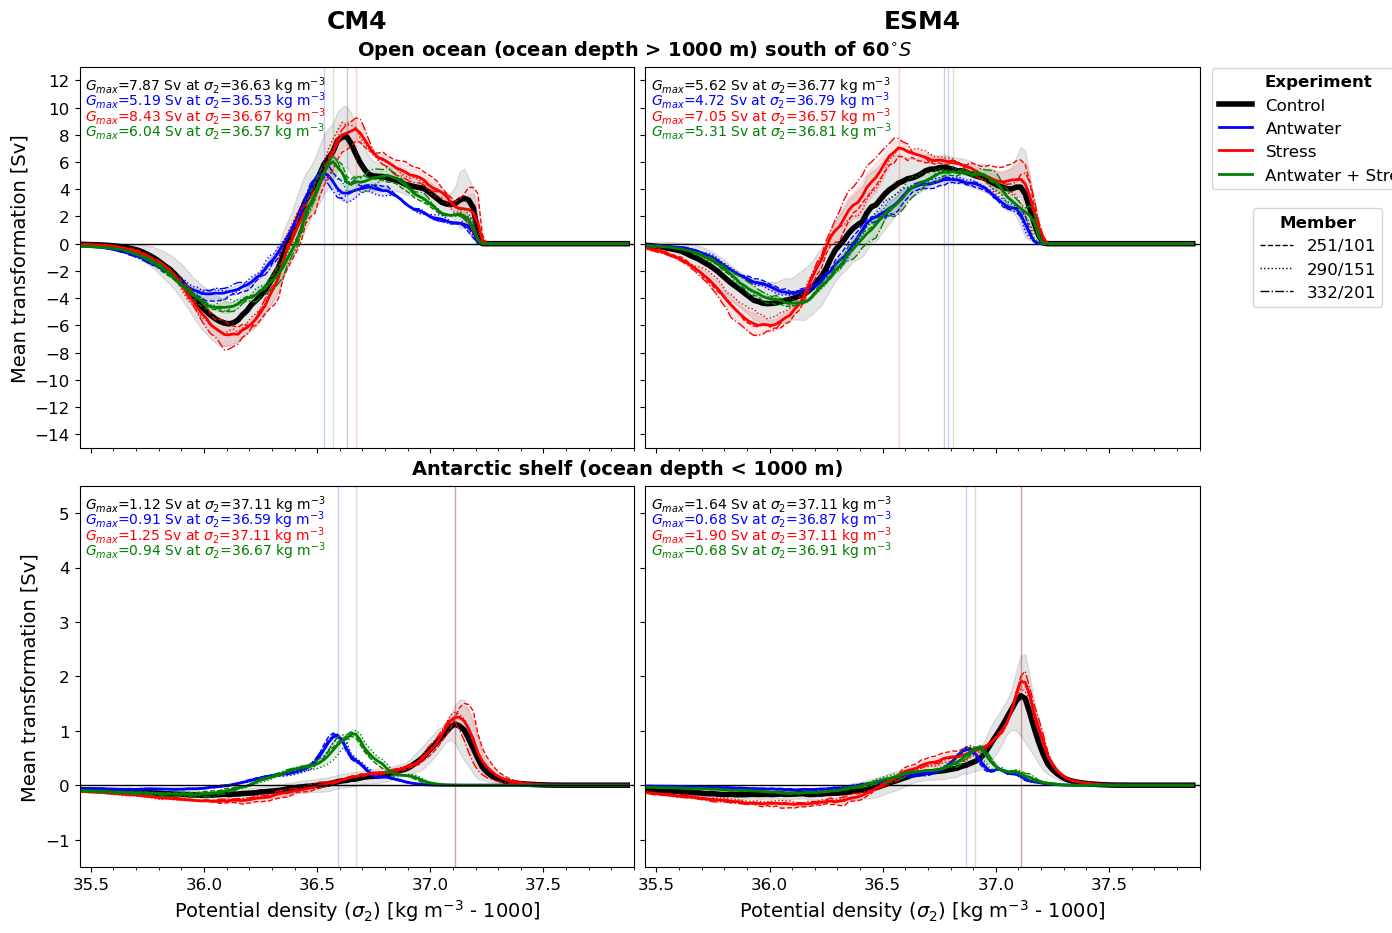

In [7]:
var = 'heat' # total, heat, salt
cstr = ['k','b','r','g']
lsty = ['--',':','-.']

fig, axs = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(14,10))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.1, wspace=0.02)

for i, mod in enumerate(ddict):
    for j, reg in enumerate(['offshr','onshlf']):
        axs[i,j].axhline(y=0, xmin=0, xmax=1, c = 'k', lw=1.0, ls='-')
        
        for k, exp in enumerate(ddict[mod]):
            
            if exp!='control':
                da = mndict[mod][exp][reg+'_'+var]
                axs[j,i].fill_between(da[lstr], da.mean('mem')-da.std('mem'), da.mean('mem')+da.std('mem'), 
                                      alpha=0.1, edgecolor=cstr[k], facecolor=cstr[k])
                
                for m, mem in enumerate(ddict[mod][exp]):
                    axs[j,i].plot(da[lstr], da.sel(mem=int(mem)), color=cstr[k], ls=lsty[m], lw=1, label=mem)
                    
            else:
                yr_st = tctr_cm4[0] if mod=='CM4' else tctr_esm4[0]
                yr_ed = tctr_cm4[1] if mod=='CM4' else tctr_esm4[1]
                da = ddict[mod][exp].sel(time=slice(yr_st,yr_ed))[reg+'_'+var]*1e-6
                axs[j,i].fill_between(da[lstr], 
                                      da.mean('time')-da.groupby('time.year').mean('time').std('year'), 
                                      da.mean('time')+da.groupby('time.year').mean('time').std('year'), 
                                      alpha=0.1, edgecolor=cstr[k], facecolor=cstr[k])
    
            da = mndict[mod][exp][reg+'_'+var] if exp =='control' else mndict[mod][exp][reg+'_'+var].mean('mem')
            
            sig_max = np.round(da[da.argmax()][lstr].values,2)
            G_max = np.round(da[da.argmax()].values,2)
            axs[j,i].axvline(x=sig_max, c = cstr[k], ls='-', lw=1, alpha=0.2,
                             label=r'$G_{max}$=%.2f Sv at $\sigma_%s$=%.2f kg m$^{-3}$'%(G_max,lstr[-1],sig_max))
            axs[j,i].text(0.01, 0.98-k/25, 
                          r'$G_{max}$=%.2f Sv at $\sigma_%s$=%.2f kg m$^{-3}$'%(G_max,lstr[-1],sig_max), 
                          ha='left', va='top', fontsize=10, c = cstr[k], transform=axs[j,i].transAxes)
            
            if exp=='control':
                p1, = axs[j,i].plot(mndict[mod][exp][lstr], mndict[mod][exp][reg+'_'+var], 
                                    c=cstr[k], ls='-', lw=4, label=exp.capitalize())
            elif exp=='antwater':
                p2, = axs[j,i].plot(mndict[mod][exp][lstr], mndict[mod][exp][reg+'_'+var].mean('mem'), 
                                    c=cstr[k], ls='-', lw=2, label=exp.capitalize())
            elif exp=='stress':
                p3, = axs[j,i].plot(mndict[mod][exp][lstr], mndict[mod][exp][reg+'_'+var].mean('mem'), 
                                    c=cstr[k], ls='-', lw=2, label=exp.capitalize())
            elif exp=='antwaterstress':
                p4, = axs[j,i].plot(mndict[mod][exp][lstr], mndict[mod][exp][reg+'_'+var].mean('mem'), 
                                    c=cstr[k], ls='-', lw=2, label=exp[:8].capitalize()+' + '+exp[8:].capitalize())
                for m, mem in enumerate(ddict[mod][exp]):
                    da = mndict[mod][exp][reg+'_'+var]
                    p5, = axs[j,i].plot(da[lstr]*(-1), da.isel(mem=0), color='k', ls=lsty[0], lw=1, label='251/101')
                    p6, = axs[j,i].plot(da[lstr]*(-1), da.isel(mem=1), color='k', ls=lsty[1], lw=1, label='290/151')
                    p7, = axs[j,i].plot(da[lstr]*(-1), da.isel(mem=2), color='k', ls=lsty[2], lw=1, label='332/201')
            
        axs[j,i].tick_params(axis='both', which='major', labelsize=12)
        
        if lstr=='sigma2':
            axs[j,i].set_xlim([35.45,37.8])
            axs[j,i].set_xticks(np.arange(35.5,38,0.1), minor=True)
        elif lstr=='sigma1':
            axs[j,i].set_xlim([31.1,33.1])
            axs[j,i].set_xticks(np.arange(31.2,33,0.2))#, minor=True)
            
        if reg != 'onshlf':
            axs[j,i].set_xticklabels([])
            axs[j,i].set_ylim([-15,13])
            axs[j,i].set_yticks(np.arange(-14,14,2))
        else:
            axs[j,i].set_xlabel('Potential density ($\sigma_%s$) [kg m$^{-3}$ - 1000]'%lstr[-1],fontsize=14)
            axs[j,i].set_ylim([-1.5,5.5])
            axs[j,i].set_yticks(np.arange(-1,6,1))
            
        if mod == 'CM4':
            axs[j,i].set_ylabel('Mean transformation [Sv]',fontsize=14)
        else:
            axs[j,i].set_yticklabels([])
            
axs[0,0].text(0.5, 1.03, 'Open ocean (ocean depth > 1000 m) south of 60$^{\circ}S$', 
              fontsize=14, fontweight='bold',transform=axs[0,0].transAxes)
axs[1,0].text(0.6, 1.03, 'Antarctic shelf (ocean depth < 1000 m)', 
              fontsize=14, fontweight='bold', transform=axs[1,0].transAxes)

for i, ax in enumerate(axs.flatten()[:2]):
    ax.set_title(list(ddict.keys())[i], fontweight='bold',fontsize=18, y=1.08)
    

leg1 = axs[0,1].legend(handles=[p1,p2,p3,p4],frameon=True, fancybox=True, bbox_to_anchor=(1.42, 1.02), 
                       loc='upper right', ncol=1, fontsize=12, title='Experiment')
plt.setp(leg1.get_title(),fontsize=12,fontweight='bold')
axs[0,1].add_artist(leg1)
leg2 = axs[0,1].legend(handles=[p5, p6, p7],frameon=True, fancybox=True, bbox_to_anchor=(1.345, 0.65), 
                       loc='upper right', ncol=1, fontsize=12, title='Member')
plt.setp(leg2.get_title(),fontsize=12,fontweight='bold')
plt.show()